# 2. Double Deep Q-Learning for Navigation
---

In this notebook I will solve the [Unity ML Banana-Collector environment](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#banana-collector) using Deep Q-Learning as described in [Human-level control through deep reinforcement learning](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf). In follow up notebooks I'll improve on this solution by implementing a double [DQN](https://arxiv.org/pdf/1509.06461.pdf), a [dueling DQN](https://arxiv.org/pdf/1511.06581.pdf), and [prioritized experience replay](https://arxiv.org/pdf/1511.05952.pdf).

In [1]:
from dqn_agent import Agent, TAU
import torch.nn.functional as F
from trainer import train
from unityagents import UnityEnvironment

In [2]:
class DoubleQAgent(Agent):
    
    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get predicted actions for next states from local model
        next_actions = self.qnetwork_local(next_states).detach().argmax(1).unsqueeze(1)
        Q_targets_next = self.qnetwork_target(next_states).gather(1, next_actions)

        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)


        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     




In [3]:
env = UnityEnvironment(file_name="./data/Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Episode 100	Average Score: 0.22
Episode 200	Average Score: 2.56
Episode 300	Average Score: 7.68
Episode 400	Average Score: 10.49
Episode 500	Average Score: 12.77
Episode 531	Average Score: 13.06
Environment solved in 431 episodes!	Average Score: 13.06


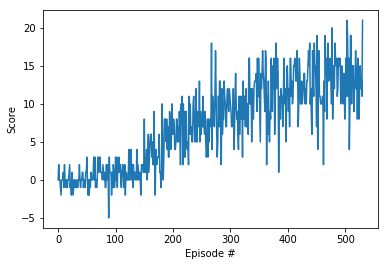

In [4]:
agent = DoubleQAgent(state_size=37, action_size=4, seed=0)

scores = train(env, agent)
